# LAB3 - Uczenie sieci neuronowych z wykorzystaniem GPU

Przedmiot: _Sztuczna Inteligencja w Systemach Informatycznych_

Autor: Tomasz Szydło

kontakt: tszydlo@agh.edu.pl

Celem laboratorium jest porównanie czasu uczenia sieci neuronowych z wykorzystaniem CPU oraz GPU. Przedmiotem uczenia będzie sieć rozpoznająca cyfry pisane odręcznie. W procesie uczenia zostanie wykorzystany zbiór MNIST:

http://yann.lecun.com/exdb/mnist/


Laboratorium może być zrealizowane w dwóch środowiskach pracy:
 * Google Colab w chmurze obliczeniowej;
 * lokalnie na komputerze wyposażonym w GPU.


## Środowisko pracy - Google Codelab

https://codelabs.developers.google.com/?cat=Machine+Learning

Dostęp do notatnika: https://colab.research.google.com

Włączenie/wyłączenie wsparcia GPU odbywa się poprzez zmianę opcji środowiska uruchomieniowego:
 * Runtime -> Change runtime type -> Hardware accelerator -> None/GPU


## Środowisko pracy - PC + GPU/CUDA + Anaconda

Realizacja laboratorium wymaga Anacondy ze środowiskami:
 * tensorflow
 * tensorflow_gpuenv
 
Różnica pomiędzy nimi polega na wykorzystaniu implementacji biblioteki Tensorflow z NVidia CUDA.

Tworzenie środowisk:
 * wersja z CPU:

```
conda create -n tensorflow_env tensorflow
conda activate tensorflow_env
```

 * wersja z GPU:

```
conda create -n tensorflow_gpuenv tensorflow-gpu
conda activate tensorflow_gpuenv
```

Za pomocą Anaconda Navigator uruchamiamy Jupyter Notebook w konkretnym środowisku - tylko CPU lub ze wsparciem GPU.


## Sieć neuronowa dla zbioru MNIST

Przygotowanie środowiska - należy uruchomić notatnik z obliczeniami wyłącznie na CPU.

In [0]:
try:
  %tensorflow_version 2.x
except:
  pass

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils

plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

In [37]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


Zwizualizuj przykładowe dane.

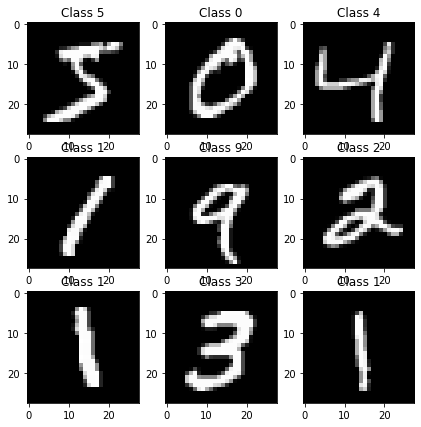

In [38]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

Sieć neuronowa przyjmuje na wejściu jeden wektor dla każdego przykładu treningowego, więc konieczne jest przekształcenie danych wejściowych, aby każdy obraz 28 x 28 stał się pojedynczym wektorem 784 wymiarowym. 

Skalujemy również dane wejściowe w zakresie [0–1] zamiast [0–255]

In [39]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


Zmodyfikuj macierze wyjść korzystając z techniki One Hot Encoding, tj.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
```
itp.

In [0]:
Y_train = np_utils.to_categorical(y_train, num_classes=10)
Y_test = np_utils.to_categorical(y_test, num_classes=10)

Zbuduj sieć neuronową. Na potrzeby zajęć sieć będzie posiadała 3 w pełni połączone warstwy.

In [0]:
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
                           
model.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax')) # w celu zapewnienia rozkładu wyjść sumującego się do 1

Kolejnym krokiem jest kompilacja modelu. Biblioteka Keras jest wysokopoziomowym API upraszczającym tworzenie i uczenie sieci neuronowych z wykorzystaniem biblitoeki Tensorflow. Podczas kompilacji sieci, biblioteka Keras wymaga określenia funkcji strat oraz algorytmu optymalizującego proces uczenia.

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
from time import time
class TimingCallback(Callback):
  def __init__(self):
    self.logs=[]
  def on_epoch_begin(self, epoch, logs={}):
    self.starttime=time()
  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(time()-self.starttime)

Po kompilacji modelu sieci neuronowej można przystąpić do uczenia sieci. Ze względu na fakt, że Jupyter notebook został uruchiomy w środowisku z biblioteką Tensorflow bez wsparcia dla GPU, to obliczenia będa wykonywane tylko i wyłącznie na CPU.

In [44]:
cb = TimingCallback()
model.fit(X_train, Y_train,
          batch_size=128, epochs=16,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=[cb])
print(cb.logs)

Epoch 1/16
469/469 [==============================] - 7s 15ms/step - loss: 0.2445 - val_loss: 0.1105
Epoch 2/16
469/469 [==============================] - 7s 15ms/step - loss: 0.1032 - val_loss: 0.0809
Epoch 3/16
469/469 [==============================] - 7s 15ms/step - loss: 0.0710 - val_loss: 0.0700
Epoch 4/16
469/469 [==============================] - 7s 15ms/step - loss: 0.0565 - val_loss: 0.0658
Epoch 5/16
469/469 [==============================] - 7s 15ms/step - loss: 0.0438 - val_loss: 0.0676
Epoch 6/16
469/469 [==============================] - 7s 15ms/step - loss: 0.0406 - val_loss: 0.0621
Epoch 7/16
469/469 [==============================] - 7s 15ms/step - loss: 0.0344 - val_loss: 0.0700
Epoch 8/16
469/469 [==============================] - 7s 15ms/step - loss: 0.0316 - val_loss: 0.0674
Epoch 9/16
469/469 [==============================] - 7s 15ms/step - loss: 0.0279 - val_loss: 0.0750
Epoch 10/16
469/469 [==============================] - 7s 15ms/step - loss: 0.0264 - val_lo

## Ewaluacja sieci neuronowej dla zbioru MNIST

Test score: 0.07729221880435944


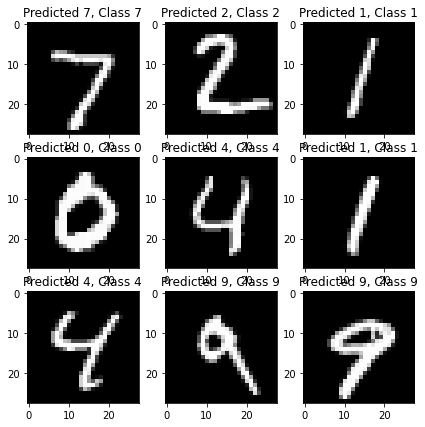

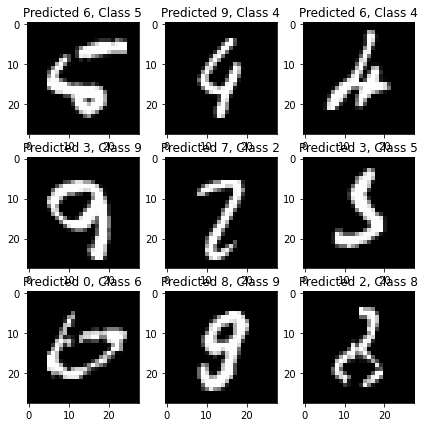

In [45]:
score = model.evaluate(X_test, Y_test,verbose=0)
print('Test score:', score)

predicted_classes = np.argmax(model.predict(X_test), axis=-1)
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

## Analiza czasu uczenia sieci z wykorzystaniem CPU oraz przy wsparciu GPU

Uzupełnij poniższy fragment kodu wpisując dane dotyczące czasu obliczeń dla każdej z szesnastu epok uczenia sieci neuronowej.

In [46]:
cpu_epoch_time = cb.logs
cpu_score = sum(cpu_epoch_time)/16
print(cpu_score)

6.955673351883888


Uaktywnij wsparcie GPU dla obliczeń i uruchom ponownie proces uczenia sieci neuronowej na bazie MNIST i uzupełnij fragment kodu poniżej.

W przypadku środowiska Anaconda zamknij środowisko *tensorflow\_env* i uruchom środowisko *tensorflow\_gpuenv*. W przypadku Google Colab zmień ustawienia środowiska uruchomieniowego.



In [47]:
gpu_epoch_time = cb.logs
print(gpu_epoch_time)
gpu_score = sum(gpu_epoch_time)/16
print(gpu_score)

[7.268893718719482, 6.95553183555603, 6.989343166351318, 7.07723331451416, 6.955023288726807, 6.8756630420684814, 6.902428388595581, 6.928835153579712, 6.825585126876831, 6.952507495880127, 6.943229675292969, 6.84466290473938, 7.041868209838867, 6.9099955558776855, 6.8582847118377686, 6.961688041687012]
6.955673351883888


Zwizualizuj i przeanalizuj czas uczenia sieci neuronowej z CPU i GPU.

{'boxes': [<matplotlib.lines.Line2D at 0x7f98a8d5c278>],
 'caps': [<matplotlib.lines.Line2D at 0x7f98a8cf65f8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f98a8cff0b8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f98a8cf6cf8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f98a8d6aeb8>,
  <matplotlib.lines.Line2D at 0x7f98a8cf6278>]}

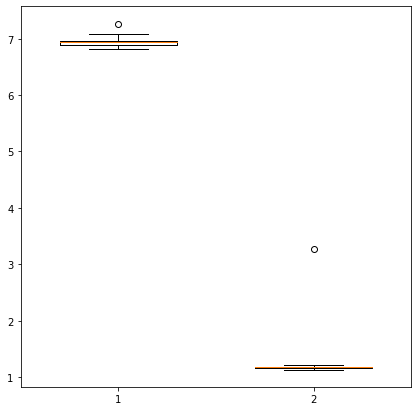

In [55]:
#TODO przedstaw czas obliczeń gpu_epoch_time, cpu_epoch_time na wykresie pudełkowym
cpu = [7.268893718719482, 6.95553183555603, 6.989343166351318, 7.07723331451416, 6.955023288726807, 6.8756630420684814, 6.902428388595581, 6.928835153579712, 6.825585126876831, 6.952507495880127, 6.943229675292969, 6.84466290473938, 7.041868209838867, 6.9099955558776855, 6.8582847118377686, 6.961688041687012]
gpu = [3.269700288772583, 1.169179916381836, 1.1496820449829102, 1.1813890933990479, 1.1765873432159424, 1.2046337127685547, 1.175978660583496, 1.1880884170532227, 1.1729881763458252, 1.1645348072052002, 1.1626954078674316, 1.1435003280639648, 1.2020297050476074, 1.1326234340667725, 1.157735824584961, 1.1583926677703857]
plt.boxplot(cpu, positions=[1], widths = 0.6)
plt.boxplot(gpu, positions=[2], widths = 0.6)


**Wnioski**
Test score: 0,07. Jest dość bliskie do 0, co jest dobrym wynikiem. Z GPU o wiele razy szybciej. Nie korzystałam z własnej GPU

*#TODO W przypadku korzystania z własnej karty GPU podaj specyfikację techniczą komputera i karty graficznej.*

